The Augmented Lagrangian
$$
L_{\sigma}(c,b,u;\lambda)=\frac{1}{2}c^{\top}Kc+C\|u_+\|_0+\frac{\sigma}{2}\|u-\big({\mathbf 1}-{\rm diag}(y)K c-b*y-\frac{\boldsymbol{\lambda}}{\sigma}\big)\|^2-\frac{\|\boldsymbol{\lambda}\|^2}{2\sigma}.
$$

In [73]:
# coding=utf-8
#L01 Proximal Operator Prox_{gamma C||(.)_+||}(eta)=argmin_{v} C||(v)_+||_0+1/(2gamma)||v-eta||^2
def Prox(eta,threshold):
    eta[np.where(np.logical_and(eta>0,eta<=threshold))] = 0  #threshold=np.sqrt(2*gamma*C)
    return eta

In [74]:
#Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels  
import time

In [75]:
# parameters
[n_samples,C,C1,C2] = [1000,64,32,16]

In [76]:
#Dataset: Double Moons
#sklearn.datasets.make_moons:https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
from sklearn.datasets import make_moons
random.seed(6)
X,Y = make_moons(n_samples,shuffle=True,noise=0.1,random_state=3) #noise level=0.1

In [77]:
from sklearn import preprocessing 
Y[np.where(Y==0)]=-1  #Transform label 0，1 to label -1，1
Standardscaler = preprocessing.StandardScaler() 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
X = Standardscaler.fit_transform(X)

# #Label noise  ratio r=0%，1%,5%,10%
# index_labelnoise=random.sample(range(len(Y)),50) # 2*r%*500 percent of label noise
# #print(index_labelnoise)
# Y[index_labelnoise]=-Y[index_labelnoise]

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.4,random_state=33)
print('X train shape',X_train.shape)
print('X test shape',X_test.shape)

X train shape (600, 2)
X test shape (400, 2)


L01KSVMTrain

In [78]:
#L01KSVMTrain
start = time.time()
K = pairwise_kernels(X_train, Y=None, metric='rbf')  # ‘linear’, ‘poly’, ‘rbf’, ‘laplacian
y = y_train
m=np.shape(X_train)[0]

    
#Initialization
c = np.zeros(m)               #coefficients
b=0                           #b=1,-1 bias
u = np.random.random(m)       #loss
Lambda = np.random.random(m)  #Multipliers
max_iter=2000                 #Maximum iteration
beta=np.zeros(4)              #KKT error
tol=1e-3                      #KKT tolerance level 

#Best parameters obtained by Gridseach
# C=64             #C=1,2,4,8,16,32,64
sigma=1         #by default=1
iota=1          #learning_rate=iota*sigma by default=1
#acc=np.zeros(max_iter)

for i in range(max_iter): 
          
    #updating u
    u_k=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y 
    eta=u_k- Lambda/sigma # eta=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y #np.dot(np.dot(y_diag,K),c)=np.multiply(y,np.dot(K,c))    
    u = Prox(eta,2*C/sigma)   
            
    #updating c   
    xi = np.ones(m)-u- b*y-Lambda/sigma
    c = linalg.solve(K+np.eye(m)/sigma,np.multiply(y,xi))   #np.dot(y_diag,xi)=np.multiply(y,xi)
        
    #updating b
    r = np.ones(m)- u- np.multiply(y,np.dot(K,c))-Lambda/sigma
    b = np.dot(y.T,r)/m
    
    #updating Lambda 
    w = u + np.multiply(y,np.dot(K,c)) + b*y - np.ones(m) 
    index = np.where(u==0)[0]
    index_c= np.nonzero(u)[0]
    Lambda[index]=Lambda[index]+iota*sigma*w[index]      
    Lambda[index_c]=0
    
#     #Accuracy stopping rule
#     acc[i]=accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train)
#     if np.logical_and(i>5,acc[i]>0.8):
#         if np.std(acc[i-3:i],ddof=1)<1e-3:
#             print('Accuracy is stable when i=',i+1)
#             break
            
    #proximal stationary point stopping rule
    beta[0]=np.linalg.norm(c+np.multiply(y,Lambda),2)/(1+np.linalg.norm(c,2))#c related to lambda；
    beta[1]=(np.abs(np.dot(y.T,Lambda)))/m  
    beta[2]=np.linalg.norm(w,2)/np.sqrt(m)  
    beta[3]=np.linalg.norm(u_k-u,2)/(1+np.linalg.norm(u,2)) 
    #print('KKT error beta',beta.T)
    if  np.amax(beta)<tol: 
        print('KKT condition (tolerance level=1e-4) is satisfied with iteration i:=',i+1)
        break  

Iter = i+1 
end = time.time()
print('Program time of L01KSVM is:%ss'%(str(end-start)))

KKT condition (tolerance level=1e-4) is satisfied with iteration i:= 559
Program time of L01KSVM is:5.759622812271118s


In [80]:
#L01KSVM Accuracy 
print('Train Accuracy:\n', accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
K_test = pairwise_kernels(X_test,X_train, metric='rbf') 
print('Test Accuracy:\n', accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))

Train Accuracy:
 1.0
Test Accuracy:
 0.995


Gaussian Kernel SVM with the Hinge Loss: ℓ1-KSVM

In [81]:
#Dual SVM Algorithm: Stochastic Gradient Ascent
#Reference: Mohammed J. Zaki, Wagner Meira  Jr., Data Mining and Machine Learning Fundamental Concepts and Algorithms (2nd, 2020),p.540
#kernel matrix, hinge loss
C1=8
start1 = time.time()
K1 = pairwise_kernels(X_train, Y=None, metric='rbf')  # ‘linear’, ‘poly’, ‘rbf’, ‘laplacian
Ktilde=K1+1  #augmented kernel matrix
m=np.shape(X_train)[0]
a=np.random.random(m)
for k in range(100):
    ak=a.copy()
    for i in range(m):
        ak[i]=ak[i]+(1-y_train[i]*np.dot(np.multiply(ak,y_train),Ktilde[i,:]))/(K1[i,i]+1)
        if ak[i]<0:
            ak[i]=0
        elif ak[i]>C1:
            ak[i]=C1
        else:
            ak[i]=ak[i]
#     print(np.linalg.norm(ak-a,2))
    if np.linalg.norm(ak-a,2)<0.12:
        print('The stop rule is satisfied with k=',k)
        break
    else:
        a=ak.copy()

end1 = time.time()
Iter1 = k+1
print('Train Accuracy:\n', accuracy_score(np.sign(np.dot(Ktilde,np.multiply(a,y_train))),y_train))
K_test1 = pairwise_kernels(X_test,X_train, metric='rbf') +1
print('Test Accuracy:\n', accuracy_score(np.sign(np.dot(K_test1,np.multiply(a,y_train) )),y_test))

Train Accuracy:
 1.0
Test Accuracy:
 0.9925


Gaussian Kernel SVM with Squared Hinge Loss

In [82]:
#Standard Gaussian Kernel SVM with Squared Hinge Loss
#Best parameter obtained by Gridsearch
start1 = time.time()
#if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
clf=SVC(C2,kernel='rbf').fit(X_train,y_train)  #default='squared_hinge'
end1 = time.time()
#print('Indices of support vectors for HingeKSVM:\n',clf.support_)
support_vectors =clf.support_vectors_  #Support vectors.
#Decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
decision_function = clf.decision_function(X_train)
support_vector_indices_canonical = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
#print('Total number of SV on canonical hyperplane:',support_vector_indices_canonical.shape[0])

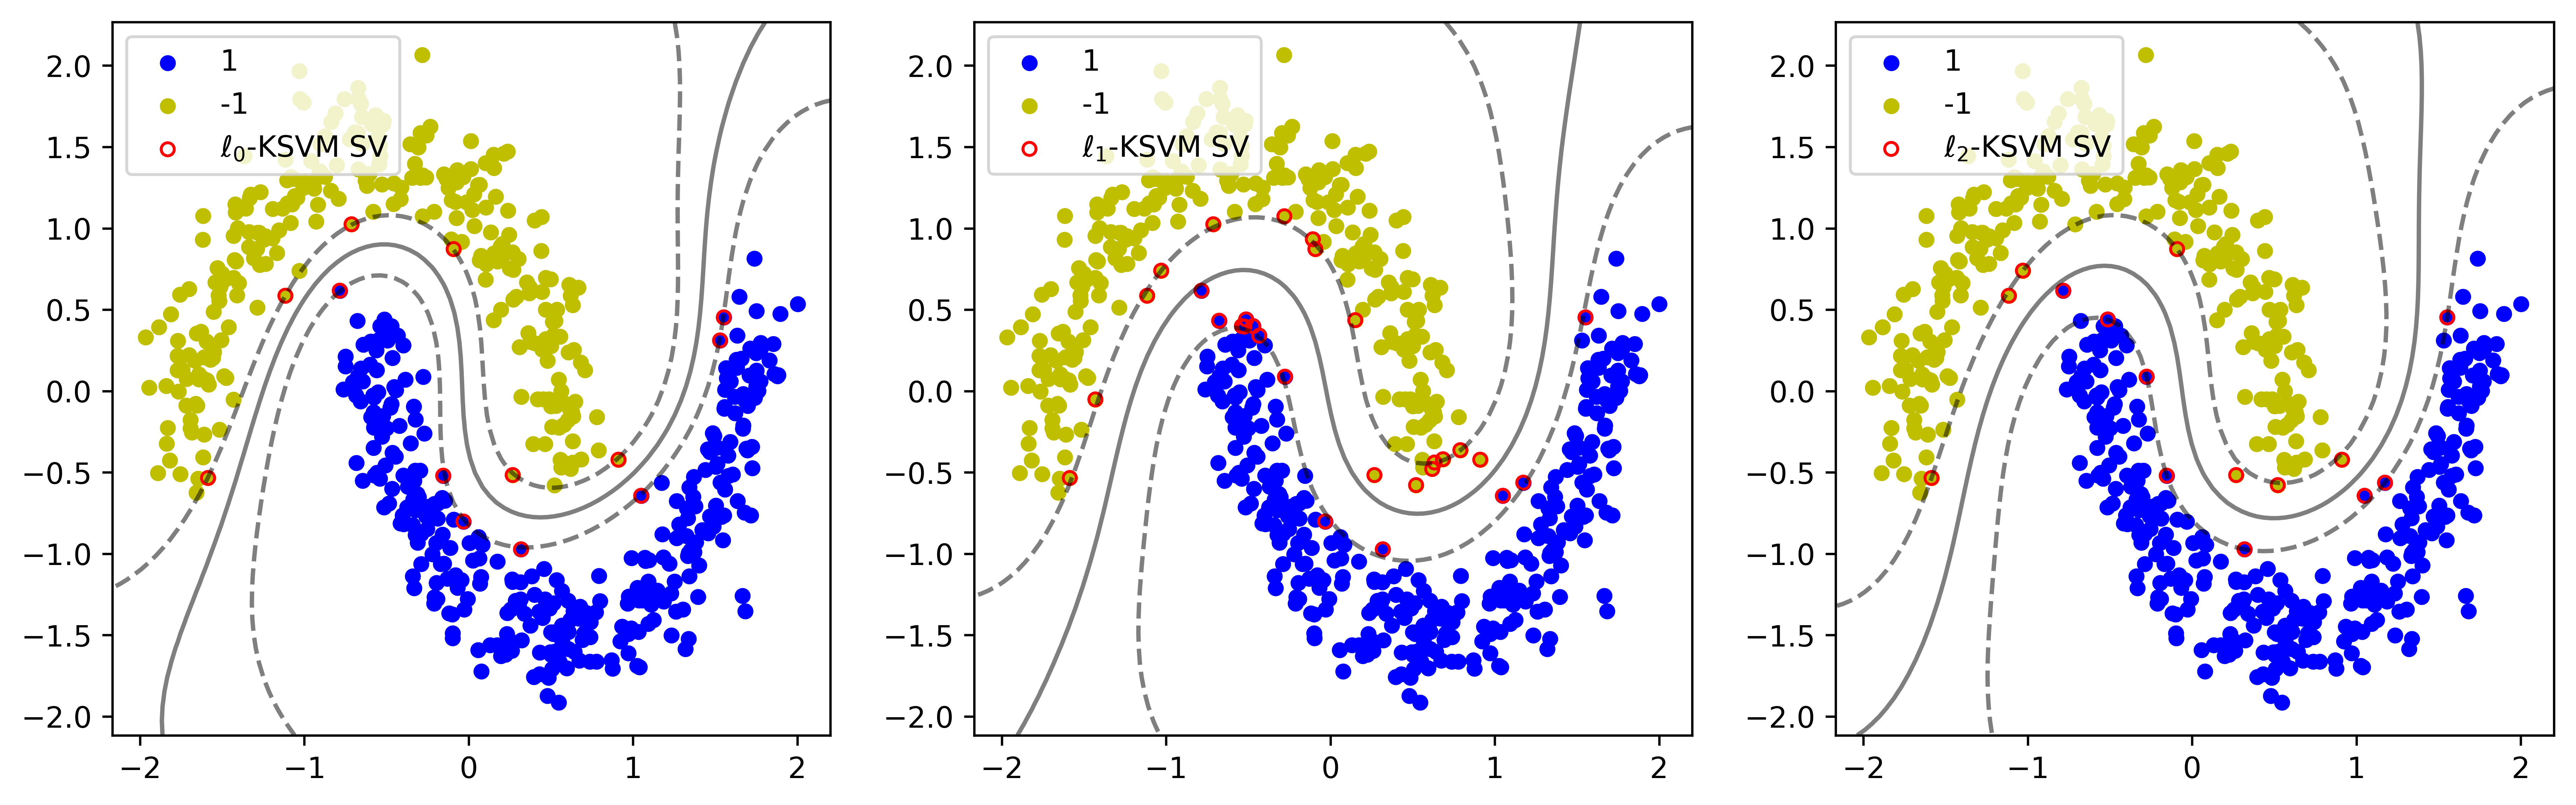

In [83]:
#Standard Gaussian Kernel SVM with Squared Hinge Loss
#Best parameter obtained by Gridsearch
start2 = time.time()
#if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
clf=SVC(C2,kernel='rbf').fit(X_train,y_train)  #default='squared_hinge'
end2 = time.time()
#print('Indices of support vectors for HingeKSVM:\n',clf.support_)
support_vectors =clf.support_vectors_  #Support vectors.
#Decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
decision_function = clf.decision_function(X_train)
support_vector_indices_canonical = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]

plt.rcParams['figure.figsize'] = (15.0, 4.5) 
plt.subplot(1,3,1)
#plt.rcParams['figure.dpi'] = 200 #分辨率

plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 600
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
K_classifier = pairwise_kernels(np.c_[xx.ravel(), yy.ravel()],X_train, metric='rbf') 
Y_classifiervalue=-np.dot(K_classifier,np.multiply(Lambda,y) ) + b  
Z=Y_classifiervalue.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
index_sv=np.nonzero(Lambda)[0] 
sv_L01Loss = X_train[index_sv]  #support vectors for L01KSVM
plt.scatter(sv_L01Loss[:, 0],sv_L01Loss[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_0$-KSVM SV')
plt.legend(loc = 'upper left')
#plt.title('L01KSVM',fontsize=10)
#plt.savefig('L01KSVM__DoubleMoons.png', bbox_inches='tight')


# ##L1KSVM:plot the decision function 
plt.subplot(1,3,2)
plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 600
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
K_classifier1 = pairwise_kernels(np.c_[xx.ravel(), yy.ravel()],X_train, metric='rbf') +1
Y_classifiervalue1=np.dot(K_classifier1,np.multiply(a,y_train) )   
Z=Y_classifiervalue1.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
index_sv1=np.nonzero(a)[0] 
sv_L1Loss = X_train[index_sv1]  #support vectors for L01KSVM
plt.scatter(sv_L1Loss[:, 0],sv_L1Loss[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_1$-KSVM SV')
plt.legend(loc = 'upper left')


# #HingeKSVM (L2KSVM):plot the decision function
plt.subplot(1,3,3)
plt.rcParams['figure.dpi'] = 600 #分辨率
plt.rcParams['font.size'] = '10'
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
plt.scatter(support_vectors[:, 0],support_vectors[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_2$-KSVM SV')
plt.legend(loc = 'upper left')
plt.savefig('KSVM_DoubleMoonLabel1_500.png', bbox_inches='tight')

In [84]:
#Summary
#L01KSVM 
print({'C':C,'sigma':sigma,'iota':iota,'C1':C1,'C2':C2})
print('Threshold',np.sqrt((2*C)/sigma))

#dataset
print('Number of Training Data',m)
print('Number of Testing Data',y_test.shape[0])

#Accuracy
print('Train Accuracy of L01KSVM:',accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
print('Test Accuracy of  L01KSVM:',accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))
print('Train Accuracy of L1KSVM:',accuracy_score(np.sign(np.dot(Ktilde,np.multiply(a,y_train))),y_train))
print('Test Accuracy of  L1KSVM:',accuracy_score(np.sign(np.dot(K_test1,np.multiply(a,y_train) )),y_test))
print('Train accuracy of HingeKSVM:',clf.score(X_train,y_train))
print('Test accuracy of HingeKSVM:',clf.score(X_test,y_test))

# Iteration
print('Iteration of L01KSVM:',Iter)
print('Iteration of L1KSVM:',Iter1)

#Number of Support Vectors
print('Number of support vectors for L01KSVM',len(index_sv))  
print('Number of support vectors for L1KSVM',len(index_sv1))  
print('Number of support vectors for HingeKSVM:',np.sum(clf.n_support_))

#Indices
print('Indices of support vectors for L01KSVM:\n',index_sv)
#print('Indices of support vectors for HingeKSVM:\n',clf.support_)

#Dual Coefficients
print('Lambda with nonzero elements for L01KSVM:\n',Lambda[np.nonzero(Lambda)])
print('Dual coefficients of the support vector in the decision function:\n',clf.dual_coef_)

#Computation Time
print('Computation Time for L01SVM',end-start)
print('Computation Time for L1SVM',end1-start1)
print('Computation Time for HingeKSVM',end2-start2)

{'C': 64, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 16}
Threshold 11.313708498984761
Number of Training Data 600
Number of Testing Data 400
Train Accuracy of L01KSVM: 1.0
Test Accuracy of  L01KSVM: 0.995
Train Accuracy of L1KSVM: 1.0
Test Accuracy of  L1KSVM: 0.9925
Train accuracy of HingeKSVM: 1.0
Test accuracy of HingeKSVM: 0.9975
Iteration of L01KSVM: 559
Iteration of L1KSVM: 100
Number of support vectors for L01KSVM 13
Number of support vectors for L1KSVM 29
Number of support vectors for HingeKSVM: 15
Indices of support vectors for L01KSVM:
 [  1   5  16 167 191 235 287 294 410 432 501 507 515]
Lambda with nonzero elements for L01KSVM:
 [-2.84882847e+00 -1.41846415e+01 -5.49180490e+00 -6.70988561e-02
 -7.89557781e+00 -8.15459185e+01 -5.44297094e+01 -1.46381534e+00
 -3.10701613e+01 -1.62496210e+01 -5.60921004e+00 -2.10210829e+01
 -3.00604689e+01]
Dual coefficients of the support vector in the decision function:
 [[-10.75494675  -2.77623601 -16.         -16.         -16.
  -16.          

Numerical Results

In [85]:
# m=500, r=0%
# {'C': 64, 'sigma': 1, 'iota': 1, 'C1': 16, 'C2': 64} 
# Threshold 11.313708498984761
# KKT error beta [0.00021288 0.00027008 0.00098283 0.00046486]
# Program time of L01KSVM is:0.393918514251709s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 0.995
# Train Accuracy of L1KSVM: 1.0
# Test Accuracy of  L1KSVM: 0.995
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Iteration of L01KSVM: 330
# Iteration of L1KSVM: 100
# Number of support vectors for L01KSVM 10
# Number of support vectors for L1KSVM 24
# Number of support vectors for HingeKSVM: 12
# Indices of support vectors for L01KSVM:
#  [  1  16  41  89 113 121 129 130 212 254]
# Indices of support vectors for HingeKSVM:
#  [  1  16  41  89 113 254  67 121 129 130 190 212]
# Lambda with nonzero elements for L01KSVM:
#  [ -0.48431511  -4.61472537  -6.71022321  -7.28876953  -1.08989921
#  -30.09221036 -16.460327   -48.04292864  -8.27173804 -82.59824673]
# Computation Time for L01SVM 0.393918514251709
# Computation Time for L1SVM 0.21921610832214355
# Computation Time for HingeKSVM 0.000997304916381836

In [86]:
# m=1000, r=0%
# {'C': 64, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 64}
# Threshold 11.313708498984761
# KKT error beta [6.71634325e-05 1.50817046e-04 9.94133782e-04 4.10929525e-04]
# Program time of L01KSVM is:5.405120611190796s
# Number of Training Data 600
# Number of Testing Data 400
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 0.995
# Train Accuracy of L1KSVM: 1.0
# Test Accuracy of  L1KSVM: 0.9925
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 0.9975
# Iteration of L01KSVM: 562
# Iteration of L1KSVM: 100
# Number of support vectors for L01KSVM 13
# Number of support vectors for L1KSVM 26
# Number of support vectors for HingeKSVM: 15
# Indices of support vectors for L01KSVM:
#  [  1   5  16 167 191 235 287 294 410 432 501 507 515]
# Indices of support vectors for HingeKSVM:
#  [  5 167 180 287 507 515 589  16  31 149 191 198 235 410 501]
# Lambda with nonzero elements for L01KSVM:
#  [-2.95324325e+00 -1.41860052e+01 -5.51862574e+00 -6.49686820e-02
#  -7.82092600e+00 -8.15741728e+01 -5.44391891e+01 -1.43673880e+00
#  -3.11112297e+01 -1.62628243e+01 -5.50946426e+00 -2.09555282e+01
#  -3.01063753e+01]
# Computation Time for L01SVM 5.405120611190796
# Computation Time for L1SVM 0.4615159034729004
# Computation Time for HingeKSVM 0.001

In [87]:
# m=1500, r=0%
# {'C': 64, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 64}
# Threshold 11.313708498984761
# KKT error beta [1.27222508e-04 9.97842199e-05 9.93598671e-04 3.78166587e-04]
# Program time of L01KSVM is:14.846288442611694s
# Number of Training Data 900
# Number of Testing Data 600
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 1.0
# Train Accuracy of L1KSVM: 1.0
# Test Accuracy of  L1KSVM: 1.0
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Iteration of L01KSVM: 628
# Iteration of L1KSVM: 100
# Number of support vectors for L01KSVM 10
# Number of support vectors for L1KSVM 25
# Number of support vectors for HingeKSVM: 11
# Indices of support vectors for L01KSVM:
#  [ 45 238 250 274 420 447 607 689 790 872]
# Indices of support vectors for HingeKSVM:
#  [ 45 238 250 274 607 872 132 244 447 689 790]
# Lambda with nonzero elements for L01KSVM:
#  [ -63.22772992  -38.97502047  -32.70785225   -2.35654877   -0.39601833
#  -106.10388771  -35.65227706  -30.57392703  -50.26823142  -14.51244181]
# Computation Time for L01SVM 14.846288442611694
# Computation Time for L1SVM 0.6841959953308105
# Computation Time for HingeKSVM 0.004012107849121094

In [88]:
# m=500,  r=1%, 
# {'C': 1, 'sigma': 2, 'iota': 1, 'C1': 1, 'C2': 4}
# Threshold 1.0377490433255416
# KKT error beta [0.05482499 0.00139885 0.03316434 0.06232891]
# Program time of L01KSVM is:2.1713600158691406s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.9833333333333333
# Test Accuracy of  L01KSVM: 0.975
# Train Accuracy of L1KSVM: 0.9833333333333333
# Test Accuracy of  L1KSVM: 0.97
# Train accuracy of HingeKSVM: 0.9833333333333333
# Test accuracy of HingeKSVM: 0.97
# Iteration of L01KSVM: 2000
# Iteration of L1KSVM: 100
# Number of support vectors for L01KSVM 23
# Number of support vectors for L1KSVM 41
# Number of support vectors for HingeKSVM: 30
# Indices of support vectors for L01KSVM:
#  [  0   1   2  16  22  41  46  67  76  87  89  99 113 121 129 130 180 190
#  205 206 217 229 263]
# Indices of support vectors for HingeKSVM:
#  [  0   1  16  41  46  89 113 136 138 139 180 202 205 217 254 276 299  22
#   67  76 121 129 130 142 186 189 190 192 206 263]
# Lambda with nonzero elements for L01KSVM:
#  [-1.73481191e+00 -7.65703794e-01 -1.30254861e+00 -1.98488309e+00
#  -2.85801006e-01 -2.57736148e-01 -2.38666325e+00 -1.71496476e+00
#  -7.91941609e-01 -7.35490812e-01 -1.80520906e+00 -1.28200572e+00
#  -7.15161260e-01 -1.86354763e+00 -1.98533194e+00 -3.31509576e-01
#   2.20433307e-02 -9.94605923e-01 -2.45150051e+00 -1.89313761e+00
#  -6.71840604e-02  1.60446558e-03 -2.62074246e+00]
# Computation Time for L01SVM 2.1713600158691406
# Computation Time for L1SVM 0.0624849796295166
# Computation Time for HingeKSVM 0.009627103805541992


In [89]:
# m=500,r=5%
# {'C': 2, 'sigma': 2, 'iota': 1, 'C1': 2, 'C2': 4}
# Threshold 1.4142135623730951
# KKT error beta [3.39463372e-02 2.52599637e-05 1.24156100e-01 1.25227884e-01]
# Iteration 2000
# Program time of L01KSVM is:2.047938108444214s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.9033333333333333
# Test Accuracy of  L01KSVM: 0.885
# Train Accuracy of L1KSVM: 0.9033333333333333
# Test Accuracy of  L1KSVM: 0.885
# Train accuracy of HingeKSVM: 0.9033333333333333
# Test accuracy of HingeKSVM: 0.885
# Iteration of L01KSVM: 2000
# Iteration of L1KSVM: 100
# Number of support vectors for L01KSVM 16
# Number of support vectors for L1KSVM 106
# Number of support vectors for HingeKSVM: 81
# Indices of support vectors for L01KSVM:
#  [  0   2  16  41  67  87  89 113 121 129 130 190 205 212 263 280]
# Indices of support vectors for HingeKSVM:
#  [  0   1   2   4  16  27  41  51  62  70  87  89  91  93 113 117 126 131
#  136 138 139 153 162 170 176 180 192 201 205 210 214 223 228 239 242 254
#  262 276 280 299   7   8  22  33  46  63  66  67  71  85  96  98  99 116
#  118 121 125 129 130 134 142 147 154 161 163 165 166 174 186 189 190 202
#  206 217 247 249 263 266 271 287 289]
# Lambda with nonzero elements for L01KSVM:
#  [-1.33628627 -4.09135187 -3.8641097  -0.61688583 -5.7639921   0.07731168
#  -2.10662912 -0.59700531 -4.19022624 -0.7512191  -0.46673932 -1.34921609
#  -2.09203736 -0.45622437 -1.77141732 -0.11446278]
# Computation Time for L01SVM 2.047938108444214
# Computation Time for L1SVM 0.15621185302734375
# Computation Time for HingeKSVM 0.009028626826313477

In [90]:
# m=500, r=10%, 
# {'C': 1.0, 'sigma': 1, 'iota': 1, 'C1': 2, 'C2': 4}
# Threshold 1.1952286093343936
# KKT error beta [0.03283595 0.0001962  0.05763996 0.05042268]
# Program time of L01KSVM is:2.119436502456665s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.7933333333333333
# Test Accuracy of  L01KSVM: 0.81
# Train Accuracy of L1KSVM: 0.7933333333333333
# Test Accuracy of  L1KSVM: 0.805
# Train accuracy of HingeKSVM: 0.7933333333333333
# Test accuracy of HingeKSVM: 0.81
# Iteration of L01KSVM: 2000
# Iteration of L1KSVM: 100
# Number of support vectors for L01KSVM 27
# Number of support vectors for L1KSVM 166
# Number of support vectors for HingeKSVM: 148
# Indices of support vectors for L01KSVM:
#  [  0   1   2  11  13  16  22  40  41  67  76  87  89 108 113 129 130 174
#  190 205 206 229 237 271 276 280 298]
# Indices of support vectors for HingeKSVM:
#  [  0   1   2   4  12  16  20  24  27  30  33  41  49  51  52  57  62  70
#   75  82  87  89  91  93  99 112 113 115 117 121 131 136 138 139 144 147
#  151 153 155 160 162 166 170 176 180 192 195 201 204 205 213 215 218 219
#  223 225 228 234 238 239 242 243 247 251 253 254 262 263 276 278 280 285
#  286 287 299   5   7   8  11  13  14  17  19  23  26  38  46  56  58  63
#   65  66  67  71  73  76  85  86  96  98 108 109 116 118 124 125 126 127
#  129 130 134 142 145 152 154 161 163 165 168 174 181 186 189 190 193 197
#  202 206 212 217 221 235 236 237 249 257 258 264 265 266 270 271 277 281
#  289 290 291 296]
# Lambda with nonzero elements for L01KSVM:
#  [-1.91480605 -0.93575639 -1.41190605 -0.0739741  -0.25848247 -1.73388933
#  -0.27879773 -0.0188927  -0.16341131 -1.35063721 -1.34558634 -1.3808382
#  -1.05967013 -0.66938723 -0.76764599 -0.75469357 -1.61966526 -1.42377248
#  -0.91589944 -1.47051965 -1.43467983 -0.58374424 -0.08943469 -1.3515662
#  -0.04276086 -0.12448243 -0.0548987 ]
# Computation Time for L01SVM 2.119436502456665
# Computation Time for L1SVM 0.21869802474975586
# Computation Time for HingeKSVM 0.015621662139892578
